In [4]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

from matplotlib.patches import Rectangle

In [4]:
(0.925 * 6.307e20) / (4 * 3.142)

4.6419279121578615e+19

In [5]:
def F_nu(t_p,nu_p,F_nup,nu_sed):
    '''Calculates a Synchrotron Self-Absorbed Spectrum for given input parameters.
     axs
    Parameters:
    t_p (days): Time of SSA peak - should be single number
    nu_p (GHz): Frequency of SSA peak - should be single number
    F_nup (mJy): Flux of SSA peak - should be single number
    nu (GHz): Frequencies at which you want the SSA spectrum to be calculated at. Likely an array.
    
    Outputs:
    Fnu (mJy): the flux of the SSA. This is an array with values associated with each value of input array nu.
    '''
    
    m = 0.88 #using stAandard model m = (n-3)/(n-2)
    p = 3.0 #using standard model
    a = (2*m)+0.5
    b = (p+5-(6*m))/2
    t=t_p
    Fnu = F_nup*1.582*(t/t_p)**a*(nu_sed/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu_sed/nu_p)**(-(p+4)/2)))
    
    return Fnu


def SSA_props(t_p,nu_p,F_nup,D_L,f=0.5,alpha=1,vw=100,epsilon_b=0.1):
    '''Calculates Synchroton Self-Absorption properties for given input parameters.
    
    Inputs:
    t_p (days): Time of SSA peak - likely a single number
    nu_p (GHz): Frequency of SSA peak - likely a single number
    F_nup (mJy): Flux of SSA peak - likely a single number
    D (Mpc): distance to SN - likely a single number,while D_L is the luminosity distance
    f (unitless): filling factor (fraction of emitting region). default is 0.5
    alpha (unitless): ratio charged particles to magnetic field (epsilon_e/epsilon_b). default 1
    v_w (km/s): wind speed. default = 100
    epsilon_b (unitless): fraction of shock energy into B-fields. default = 0.1
    
    Outputs:
    R (cm): radius of material 
    B : magnetic field flux
    E : intermal energy of emitting material
    v (km/s): expansion velocity of material
    M (1d-5 solar masses per year): inferred mass loss rate of progenitor'''
     #angular distance
    D = D_L/((1+z)**2)

    #Radius
    R = 4.0e14*(alpha)**(-1./19.)*(f/0.5)**(-1./19.)*(F_nup)**(9./19.)*(D)**(18./19.)*(nu_p/5.)**(-1)

    # Magnetic field flux
    B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

    #Internal energy of the emitting material
    E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3.)

    #expansion velocity in km/s
    v = (R/t_p)*1.1574e-10

    #pre-explosion mass-loss in 1e-5 solar mass per year --wrong
    #M = 1.0*(alpha)**(-8/19)*(epsilon_b/0.1)*(f/0.5)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(vw/1000)
    
    #pre-explosion mass-loss in 1e-5 solar mass per year ---correct
    M = 0.925*(alpha)**(-8/19)*(epsilon_b/0.1)**(-1)*(f/0.5)**(-8/19)*(F_nup)**(-4/19)*(D)**(-8/19)*(nu_p/5)**(2)*(t_p/10)**(2)*(vw/1000)
   
   

    return R,B,E,v,M


def taufreefree(M,R,nu):
    '''Calculates the free free optical depth for a given set of parameters.
    
    Inputs:
    M (1d-5 solar masses per year): mass loss rate
    R (cm): radius of emitting material
    nu (GHz): Frequencies at which you want tau-ff to be calculated at. Likely an array.
    
    Outputs:
    tau_ff (unitless): the free-free optical depth, calculated at same frequences as input array nu'''

    Z_ave = 1  # Average metallicity 1= pure H. 5.4 for a massive star
    miu = 1 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
    vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
    T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 
        
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units
    
    tau_ff = 2.021e25*M_cgs**2*Z_ave/(miu**2*nu**(2.1)*R**3*vw_cgs**2*T**(1.35))  
    
    return tau_ff

def den(M,R):
    vw_cgs = 100 * 1e5
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units 
        #density of the CSM
    density = M_cgs/(4*3.142*R**2*vw_cgs)
    
    return density


In [3]:
0.0098*1e-20 

9.8e-23

Text(0.5, 0.03, '$\\nu$(GHz)')

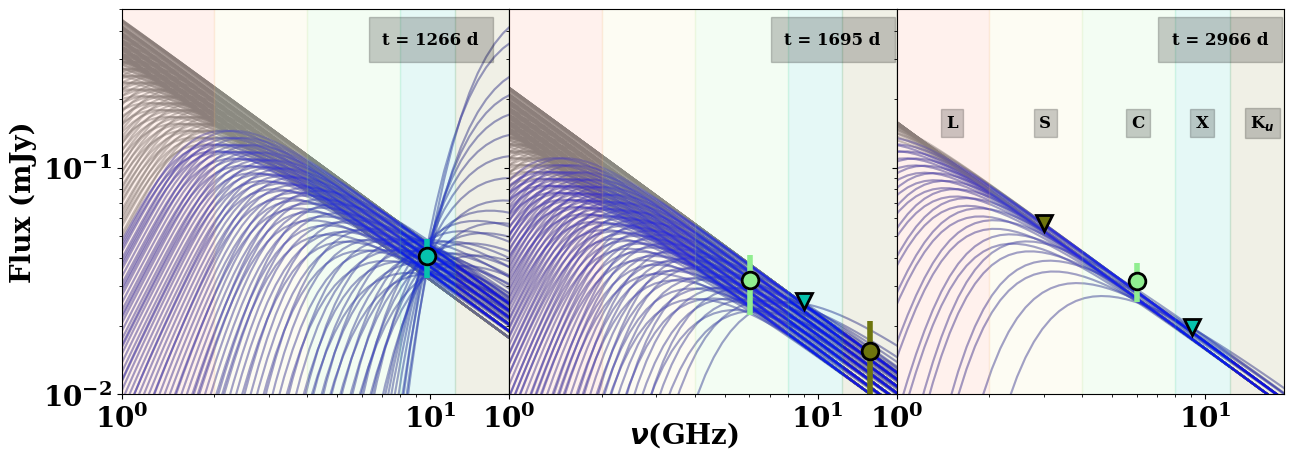

In [6]:

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 15})

from matplotlib import rc,rcParams
rc('font', weight='bold')
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

fig,subplots = plt.subplots(1, 3,figsize=(15,5), sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0})

#### LEFT: first epoch

subplots[0].set_xscale('log')
subplots[0].set_yscale('log')

file_in = 'PS11aop_grid_e1+5A.csv'
data_plot = ascii.read(file_in)
D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date 
date_obs = 57307.08 # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#

file_inc = 'PS11aop_grid_e2+5A.csv'
data_plotc = ascii.read(file_inc)

file_inb = 'PS11aop_grid_e3+5A.csv'
data_plotb = ascii.read(file_inb)
index2 = np.where(data_plotb['RuledOut'] == 'False')[0]
data_plot2b = data_plotb[index2]

#Allowed epoch 2
indexc = np.where(data_plotc['RuledOut'] == 'False')[0]
data_plot2 = data_plotc[indexc]
index2b = np.where(data_plot2['Radius'] < np.max(data_plot2b['Radius']))[0]
data_plot2d = data_plot2[index2b]
index3b = np.where(data_plot2d['v_shock'] > np.min(data_plot2b['v_shock']))[0]
data_plot2e = data_plot2d[index3b]


#Allowed epoch 1 by constrained epoch 2
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]
index2a = np.where(data_plota['Radius'] < np.max(data_plot2e['Radius']))[0]
data_plot1a = data_plota[index2a]
index3a = np.where(data_plot1a['v_shock'] > np.min(data_plot2e['v_shock']))[0]
data_plot1aa = data_plot1a[index3a]

Fcalc = data_plot1aa['F_peak']#[0:100:2]
nucalc = data_plot1aa['nu_peak']#[0:100:2]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)


###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[0].plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)

##overplot the SEDs with v_shock < 20,000km/s
Fcalc_v = data_plot1aa['F_peak'][data_plot1aa['v_shock'] <= 20000]
nucalc_v = data_plot1aa['nu_peak'][data_plot1aa['v_shock'] <= 20000]

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    subplots[0].plot(nu_sed,SSA_FFA_sedv,'b',zorder=1,alpha=0.2)
    
#Overplot the data:
subplots[0].errorbar(9.77,0.0405,0.0078,fmt ='o',color='xkcd:turquoise',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
#subplots[0].text(1.1,0.04,'Allowed',color = 'b',fontsize=15,bbox={'facecolor': 'b', 'alpha': 0.2, 'pad': 5})
#subplots[0].text(1.1,0.03,'Not Allowed',color='r',fontsize=15,bbox={'facecolor': 'r', 'alpha': 0.2, 'pad': 5})
r1e = Rectangle((1,5e-3),1,1,color='coral',alpha=0.1,zorder=1)
r2e = Rectangle((2,5e-3),2,1,color='khaki',alpha=0.1,zorder=1)
r3e = Rectangle((4,5e-3),4,1,color='lightgreen',alpha=0.1,zorder=1)
r4e = Rectangle((8,5e-3),4,1,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5e = Rectangle((12,5e-3),6,1,color='xkcd:olive',alpha=0.1,zorder=1)
r6e = Rectangle((18,5e-3),8.5,1,color='#3696e3',alpha=0.1,zorder=1)
r7e = Rectangle((26.5,5e-3),13.5,1,color='#3784c6',alpha=0.1,zorder=1)
r8e = Rectangle((40,5e-3),10,1,color='#38618c',alpha=0.1,zorder=1)

subplots[0].add_patch(r1e)
subplots[0].add_patch(r2e)
subplots[0].add_patch(r3e)
subplots[0].add_patch(r4e)
subplots[0].add_patch(r5e)
subplots[0].add_patch(r6e)
subplots[0].add_patch(r7e)
subplots[0].add_patch(r8e)

#subplots[0].text(22,1e-1,'K',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
#subplots[0].text(32,1e-1,'Ka',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
#subplots[0].text(45,1e-1,'Q',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})

#subplots[0,0].xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
subplots[0].set_ylabel('Flux (mJy)', fontsize=20, fontweight ='bold') 
#subplots[0].title.set_text('PS1-11aop 2015B Observations')   
subplots[0].title.set_fontsize(16) 
#subplots[0].set_ylim(8e-3,1e-1)
subplots[0].set_ylim(1e-2,0.5)
subplots[0].set_xlim(1,18)
#subplots[0].set_xlim(3,50)
subplots[0].text(7,0.35,'t = 1266 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})

#subplots[0].text(3.2,0.8,r'$R \sim (2-22) \times 10^{16}$ cm',fontsize=11,fontweight='bold')
#subplots[0].text(3.2,0.45,r'$v_{sh} \sim (2-20) \times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
#subplots[0].text(3.2,0.30,r'$\rho_{CSM}$ $\sim 10^{-22} - 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
#subplots[0].text(3.2,0.22,r'$\.{M} \sim (2-26) \times 10^{-5}$ M$_{\odot}$ yr$^{-1}$',fontsize=11,fontweight='bold')

#subplots[0].text(3.2,0.8,r'$R = 2.07-21.56\times 10^{16}$ cm',fontsize=11,fontweight='bold')
#subplots[0].text(3.2,0.45,r'$v_{sh} = 1.89-19.72\times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
#subplots[0].text(3.2,0.30,r'$\rho_{CSM} = 0.02-24.75\times 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
#subplots[0].text(3.2,0.27,r'$\.{M} = 2-26\times 10^{-5}$ M$_{\odot}$ yr$^{-1}$',fontsize=11,fontweight='bold')


#NEW
#1.7275550006705815 26.450863693180743
#1893.7543639432865 19718.210849807165
#1.8647381738953237e-22 2.474143466098678e-19
#2.0708158507681804e+16 2.1561816228132867e+17

####MIDDLE:Second Epoch

subplots[1].set_xscale('log')
subplots[1].set_yscale('log')


D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date
date_obs = 57829.76513 # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_inc = 'PS11aop_grid_e2+5A.csv'
data_plotc = ascii.read(file_inc)

file_inb = 'PS11aop_grid_e3+5A.csv'
data_plotb = ascii.read(file_inb)
index2 = np.where(data_plotb['RuledOut'] == 'False')[0]
data_plot2b = data_plotb[index2]

#Allowed
indexc = np.where(data_plotc['RuledOut'] == 'False')[0]
data_plot2 = data_plotc[indexc]
index2b = np.where(data_plot2['Radius'] < np.max(data_plot2b['Radius']))[0]
data_plot23 = data_plot2[index2b]
index3b = np.where(data_plot23['v_shock'] > np.min(data_plot2b['v_shock']))[0]
data_plot24 = data_plot23[index3b]

Fcalc = data_plot24['F_peak']#[0:100:5]
nucalc = data_plot24['nu_peak']#[0:100:5]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[1].plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)

##overplot the SEDs with v_shock < 20,000km/s
Fcalc_v = data_plot24['F_peak'][data_plot24['v_shock'] <= 20000]
nucalc_v = data_plot24['nu_peak'][data_plot24['v_shock'] <= 20000]

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    subplots[1].plot(nu_sed,SSA_FFA_sedv,'b',zorder=1,alpha=0.2)
    
#Overplot the data:
subplots[1].errorbar(6.05,0.0318,0.0095,fmt ='o',color='lightgreen',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
subplots[1].plot(9.02,0.0258, 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2)
subplots[1].errorbar(14.75,0.0155, 0.0056,fmt='o',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)


r1d = Rectangle((1,5e-3),1,1,color='coral',alpha=0.1,zorder=1)
r2d = Rectangle((2,5e-3),2,1,color='khaki',alpha=0.1,zorder=1)
r3d = Rectangle((4,5e-3),4,1,color='lightgreen',alpha=0.1,zorder=1)
r4d = Rectangle((8,5e-3),4,1,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5d = Rectangle((12,5e-3),6,1,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[1].add_patch(r1d)
subplots[1].add_patch(r2d)
subplots[1].add_patch(r3d)
subplots[1].add_patch(r4d)
subplots[1].add_patch(r5d)

subplots[1].title.set_fontsize(16) 
#subplots[1].set_ylim(8e-3,1e-1)
subplots[1].set_ylim(1e-2,0.5)
subplots[1].set_xlim(1,18)
subplots[1].text(7.8,0.35,'t = 1695 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})

#subplots[1].text(1.2,0.8,r'$R \sim (3-29) \times 10^{16}$ cm',fontsize=11,fontweight='bold')
#subplots[1].text(1.2,0.45,r'$v_{sh} \sim (2-20) \times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
#subplots[1].text(1.2,0.30,r'$\rho_{CSM}$ $\sim 10^{-23} - 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
#subplots[1].text(1.2,0.22,r'$\.{M} \sim (2 - 12) \times 10^{-5}$ M$_{\odot}$ yr$^{-1}$',fontsize=11,fontweight='bold')


#NEW
#1.6141202072445873 12.032175779673452
#1890.2385884001442 19609.457914970237
#9.82467120943005e-23 7.881778854940376e-20
#2.7678228526358144e+16 2.871357408420725e+17

####LEFT:Third Epoch

subplots[2].set_xscale('log')
subplots[2].set_yscale('log')


D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date 
date_obs = 59378.446209  # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_inb = 'PS11aop_grid_e3+5A.csv'
data_plot3b = ascii.read(file_inb)

#Allowed
index3b = np.where(data_plot3b['RuledOut'] == 'False')[0]
data_plot2b = data_plot3b[index3b]

Fcalc = data_plot2b['F_peak']#[0:10]
nucalc = data_plot2b['nu_peak']#[0:10]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)
#print(nu_sed)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[2].plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)
    
##overplot the SEDs with v_shock < 20,000km/s
Fcalc_v = data_plot2b['F_peak'][data_plot2b['v_shock'] <= 20000]
nucalc_v = data_plot2b['nu_peak'][data_plot2b['v_shock'] <= 20000]

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    subplots[2].plot(nu_sed,SSA_FFA_sedv,'b',zorder=1,alpha=0.2)
    
#Overplot the data:
#plt.plot(3.0,0.405, 'kv', markersize=10)
subplots[2].errorbar(5.998364,0.0317,0.0063,fmt ='o',color='lightgreen',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
subplots[2].plot(9.048039,0.019847, 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2)
#subplots[2].errorbar(2.998683,0.1274, 0.0201,fmt='o',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)
subplots[2].errorbar(2.998683,0.0567,fmt='v',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)

#Different VLA bands
r1a = Rectangle((1,5e-3),1,1,color='coral',alpha=0.1,zorder=1)
r2a = Rectangle((2,5e-3),2,1,color='khaki',alpha=0.1,zorder=1)
r3a = Rectangle((4,5e-3),4,1,color='lightgreen',alpha=0.1,zorder=1)
r4a = Rectangle((8,5e-3),4,1,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5a = Rectangle((12,5e-3),6,1,color='xkcd:olive',alpha=0.1,zorder=1)

subplots[2].add_patch(r1a)
subplots[2].add_patch(r2a)
subplots[2].add_patch(r3a)
subplots[2].add_patch(r4a)
subplots[2].add_patch(r5a)
#plot the bands 
subplots[2].text(1.45,1.5e-1,'L',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(2.9,1.5e-1,'S',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(5.75,1.5e-1,'C',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(9.3,1.5e-1,'X',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(14,1.5e-1,r'K$_u$',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})

subplots[2].title.set_fontsize(16) 
#subplots[2].set_ylim(60e-4,1e-1)
subplots[2].set_ylim(1e-2,0.5)
subplots[2].set_xlim(1,18)
subplots[2].text(7.8,0.35,'t = 2966 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})

#subplots[2].text(1.2,0.8,r'$R \sim (4-48) \times 10^{16}$ cm',fontsize=11,fontweight='bold')
#subplots[2].text(1.2,0.45,r'$v_{sh} \sim (2-19) \times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
#subplots[2].text(1.2,0.30,r'$\rho_{CSM}$ $ \sim 10^{-23} - 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
#subplots[2].text(1.2,0.22,r'$\.{M} \sim (2-14) \times 10^{-5}$ M$_{\odot}$ yr$^{-1}$',fontsize=11,fontweight='bold')


#NEW
#1.8519293176024456 13.855672091663479
#1641.4709305105812 18734.8173741703
#4.031211505554048e-23 3.9289030346625476e-20
#4.206844629371578e+16 4.8014536467161395e+17

fig.text(0.5, 0.03,r'$\nu$(GHz)',fontsize=20, va='center',ha ='center',fontweight ='bold')

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.tight_layout()
#plt.savefig('SEDps11aop5.png',dpi = 500, transparent = True)
#plt.show()


## Checking for variability of the radio source using t-statistics

In [2]:
import numpy as np
#for 9.7GHz
fluxes = [0.0405*1e-3, 0.0258*1e-3] #Jy
fluxes_err = [0.0078*1e-3,0] #Jy
n1 =0
n2 =1
S1 = fluxes[n1]  #Jy
S1_err = fluxes_err[n1] #Jy
S2 = fluxes[n2] #Jy
S2_err = fluxes_err[n2] #Jy
vs = (S1-S2)/np.sqrt(S1_err**2 + S2_err**2)
abs(vs) #not variable

1.8846153846153848

In [3]:
#for 6GHz
fluxes = [0.0318*1e-3, 0.0317*1e-3] #Jy
fluxes_err = [0.0095*1e-3, 0.0063*1e-3] #Jy
n1 =0
n2 =1
S1 = fluxes[n1]  #Jy
S1_err = fluxes_err[n1] #Jy
S2 = fluxes[n2] #Jy
S2_err = fluxes_err[n2] #Jy
vs = (S1-S2)/np.sqrt(S1_err**2 + S2_err**2)
abs(vs) #not variable

0.00877260487399311

In [77]:
#data_plot1aa[data_plot1aa['v_shock'] <= 20000]['Mdot'][60:80]

In [7]:
#-5 days explosion date epoch 1
indexv1 = (data_plot1aa['v_shock'] <= 20000)
print(np.min(data_plot1aa[indexv1]['Mdot']), np.max(data_plot1aa[indexv1]['Mdot']) ) 
print(np.min(data_plot1aa[indexv1]['v_shock']), np.max(data_plot1aa[indexv1]['v_shock']) ) 
print(np.min(data_plot1aa[indexv1]['den']), np.max(data_plot1aa[indexv1]['den']) ) 
print(np.min(data_plot1aa[indexv1]['Radius']), np.max(data_plot1aa[indexv1]['Radius']) ) 

17.7671569576574 664.0269747759771
4920.3578885390425 19718.210849807165
1.9178026637457686e-21 6.07577056678394e-19
5.3803995391579976e+16 2.1561816228132867e+17


In [14]:
#-5 days explosion date epoch 1
index1 = (data_plot1aa['v_shock'] <= 20000)
data_plot1aa_a = data_plot1aa[index1]

index1a = np.where((data_plot1aa_a['Radius'] > 2e16))[0] #based on allowed SED
data_plot1aa_b = data_plot1aa_a[index1a]
#data_plot1aa_b 
print(np.min(data_plot1aa_b['Mdot']), np.max(data_plot1aa_b['Mdot']) ) 
print(np.min(data_plot1aa_b['v_shock']), np.max(data_plot1aa_b['v_shock']) ) 
print(np.min(data_plot1aa_b['den']), np.max(data_plot1aa_b['den']) ) 
print(np.min(data_plot1aa_b['Radius']), np.max(data_plot1aa_b['Radius']) ) 

17.7671569576574 664.0269747759771
4920.3578885390425 19718.210849807165
1.9178026637457686e-21 6.07577056678394e-19
5.3803995391579976e+16 2.1561816228132867e+17


In [4]:
filename=data_plot1aa
#indexv1 = (data_plot1aa['v_shock'] > 0)
Fp_g =filename[indexv1]['F_peak']
nup_g=filename[indexv1]['nu_peak']
R_g=filename[indexv1]['Radius']
B_g=filename[indexv1]['Bfield']
vsh_g=filename[indexv1]['v_shock']
M_g=filename[indexv1]['Mdot']
den_g=filename[indexv1]['den']
RuledOut_g=filename[indexv1]['RuledOut']

file_out = 'ps11aop-epoch1-allowed.csv'
data = [Fp_g,nup_g,R_g,B_g,vsh_g,M_g,den_g,RuledOut_g]
names = ['F_peak','nu_peak','Radius','Bfield','v_shock','Mdot','den','RuledOut']
ascii.write(data,file_out,names=names,overwrite=True,format='csv')

In [36]:
#-5 days explosion date epoch 2
indexv2 = (data_plot24['v_shock'] <= 20000)
print(np.min(data_plot24[indexv2]['Mdot']), np.max(data_plot24[indexv2]['Mdot']))  
print(np.min(data_plot24[indexv2]['v_shock']), np.max(data_plot24[indexv2]['v_shock'])  )
print(np.min(data_plot24[indexv2]['den']), np.max(data_plot24[indexv2]['den'])  )
print(np.min(data_plot24[indexv2]['Radius']), np.max(data_plot24[indexv2]['Radius']) )

14.625394203987447 176.37916957711693
4597.0744488581495 19609.457914970237
8.902043894721364e-22 1.953428620180834e-19
6.731365973005022e+16 2.871357408420725e+17


In [5]:
filename=data_plot24
#indexv2 = (data_plot24['v_shock'] > 0)
Fp_g =filename[indexv2]['F_peak']
nup_g=filename[indexv2]['nu_peak']
R_g=filename[indexv2]['Radius']
B_g=filename[indexv2]['Bfield']
vsh_g=filename[indexv2]['v_shock']
M_g=filename[indexv2]['Mdot']
den_g=filename[indexv2]['den']
RuledOut_g=filename[indexv2]['RuledOut']

file_out = 'ps11aop-epoch2-allowed.csv'
data = [Fp_g,nup_g,R_g,B_g,vsh_g,M_g,den_g,RuledOut_g]
names = ['F_peak','nu_peak','Radius','Bfield','v_shock','Mdot','den','RuledOut']
ascii.write(data,file_out,names=names,overwrite=True,format='csv')

In [ ]:
#alpha = 1, eb = 0.1  first epoch (Default result)
17.7671569576574 664.0269747759771
4920.3578885390425 19718.210849807165
1.9178026637457686e-21 6.07577056678394e-19
5.3803995391579976e+16 2.1561816228132867e+17

#second epoch
14.625394203987447 176.37916957711693
4597.0744488581495 19609.457914970237
8.902043894721364e-22 1.953428620180834e-19
6.731365973005022e+16 2.871357408420725e+17

#third epoch
20.719657503613742 203.4267639721311
4280.565418464607 18734.8173741703
4.51017870529967e-22 8.482344741484655e-20    #decrease of eb, increases mass loss rates
1.0970449312641941e+17 4.8014536467161395e+17 # increase in alpha, lowers mass loss rates

In [ ]:
#alpha = 1, eb = 0.01 first epoch
177.67156957657394 1863.5952348227988
10523.016068292976 19718.210849807165
1.9178026637457685e-20 4.512474521630051e-19
1.1506892808808835e+17 2.1561816228132867e+17

#second epoch
146.25394203987443 459.9548854602421
10503.479974680517 19609.457914970237
8.90204389472136e-21 9.758029791504954e-20
1.5379948375050938e+17 2.871357408420725e+17

#third epoch
207.1965750361374 515.1300232080531
10448.668415534243 18734.8173741703
4.510178705299669e-21 3.6049983799471605e-20
2.6778375291910973e+17 4.8014536467161395e+17

In [ ]:
#alpha = 10, eb = 0.1 first epoch
5.775367990227096 377.2000025391176
3420.5973587277763 19936.65048862082
6.467174855809698e-22 6.783412941516486e-19
3.740415000179708e+16 2.180067944878282e+17

#second epoch
4.196070997367918 81.56785915331551
3327.5965085127286 19972.851354277722
2.4619317845536955e-22 1.7241342178119536e-19
4.872505363678974e+16 2.924568080977382e+17

#third epoch
5.857849830891631 91.35255327625083
3310.231715769662 19723.22879189202
1.1505150781512126e-22 6.369627060817732e-20
8.483629077201802e+16 5.054768718397536e+17

In [ ]:
#alpha = 10, eb = 0.01 first epoch
57.753679902270974 1090.1762760436357
7235.371047612268 19936.65048862082
6.4671748558097e-21 5.461970774929683e-19
7.911860871114206e+16 2.180067944878282e+17

#second epoch
41.96070997367919 277.089163991458
6834.871295381815 19972.851354277722
2.461931784553696e-21 1.3882644018484055e-19
1.0008108543691234e+17 2.924568080977382e+17

#third epoch
58.578498308916316 356.8019583048829
6340.9604749570835 19723.22879189202
1.1505150781512128e-21 6.779961737496987e-20
1.625093385652174e+17 5.054768718397536e+17

In [9]:
print(57.753679902270974/17.7671569576574 , 1090.1762760436357/664.0269747759771) #first epoch
print(58.578498308916316/20.719657503613742 , 356.8019583048829/203.4267639721311) #third epoch
print(41.96070997367919/14.625394203987447 , 277.089163991458/176.37916957711693  ) #second epoch

3.5e15cm is teh maximum blackbody radius which is around the peak 
of the bol light curve 20-23 days after explosion----strict upper limit of CSM radius

MOSFIT probed teh opther one

SyntaxError: invalid syntax (723797371.py, line 5)

In [38]:
#-5.5 days explosion date, epoch 3
indexv3 = (data_plot2b['v_shock'] <= 20000)
print(np.min(data_plot2b[indexv3]['Mdot']), np.max(data_plot2b[indexv3]['Mdot']) ) 
print(np.min(data_plot2b[indexv3]['v_shock']), np.max(data_plot2b[indexv3]['v_shock']) ) 
print(np.min(data_plot2b[indexv3]['den']), np.max(data_plot2b[indexv3]['den']) ) 
print(np.min(data_plot2b[indexv3]['Radius']), np.max(data_plot2b[indexv3]['Radius']) ) 

20.719657503613742 203.4267639721311
4280.565418464607 18734.8173741703
4.51017870529967e-22 8.482344741484655e-20
1.0970449312641941e+17 4.8014536467161395e+17


In [6]:
filename=data_plot2b
#indexv3 = (data_plot2b['v_shock'] > 0)
Fp_g =filename[indexv3]['F_peak']
nup_g=filename[indexv3]['nu_peak']
R_g=filename[indexv3]['Radius']
B_g=filename[indexv3]['Bfield']
vsh_g=filename[indexv3]['v_shock']
M_g=filename[indexv3]['Mdot']
den_g=filename[indexv3]['den']
RuledOut_g=filename[indexv3]['RuledOut']

file_out = 'ps11aop-epoch3-allowed.csv'
data = [Fp_g,nup_g,R_g,B_g,vsh_g,M_g,den_g,RuledOut_g]
names = ['F_peak','nu_peak','Radius','Bfield','v_shock','Mdot','den','RuledOut']
ascii.write(data,file_out,names=names,overwrite=True,format='csv')

In [ ]:
#alpha = 10
0.6019856371243817 5.255027162805469
1454.1245847628606 19723.22879189202
1.1823340856053407e-23 1.898811428063695e-20
3.7267039495752936e+16 5.054768718397536e+17

In [ ]:
#alpha = 1
1.8519293176024456 13.855672091663479
1641.4709305105812 18734.8173741703
4.031211505554048e-23 3.9289030346625476e-20
4.206844629371578e+16 4.8014536467161395e+17

In [85]:
alphab = 28
eb = 0.1
7.8*1e-7*alphab**(-8/19)*(eb/0.1)**(-1) #7.799999999999999e-07 for alpha = 1, 1.917630397247991e-07 for alpha = 28
#increase in alpha lowers mass loss rates

1.917630397247991e-07

<ipython-input-25-86cb269cd734>:81: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Fcalc_v = data_plot1aa['F_peak'][[data_plot1aa['v_shock'] <= 20000]]
<ipython-input-25-86cb269cd734>:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  nucalc_v = data_plot1aa['nu_peak'][[data_plot1aa['v_shock'] <= 20000]]
<ipython-input-25-86cb269cd734>:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array

Text(0.5, 0.03, '$\\nu$(GHz)')

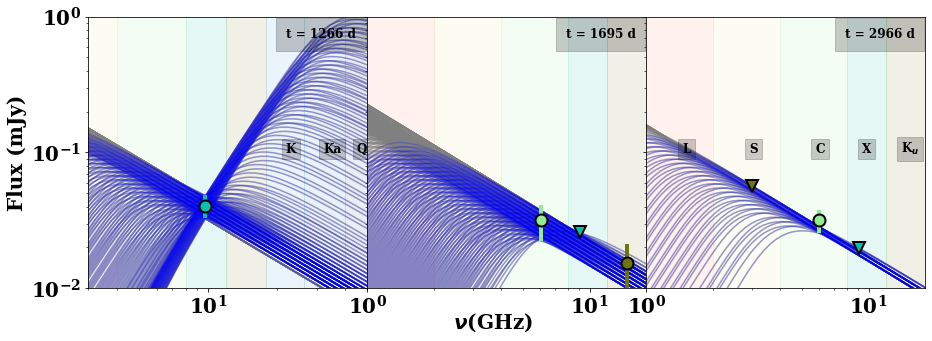

In [25]:
#plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 15})

from matplotlib import rc,rcParams
rc('font', weight='bold')
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

#figure, subplots = plt.subplots(1, 2, figsize=(18,10))
#figure.rcParams.update({'font.size': 10})
#fig = fig.add_subplot(111) 
fig,subplots = plt.subplots(1, 3,figsize=(15,5), sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0})

#### LEFT: first epoch

subplots[0].set_xscale('log')
subplots[0].set_yscale('log')

file_in = 'PS11aop_grid_e1+100A.csv'
data_plot = ascii.read(file_in)
D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 100 #55736.161 #inferred explosion date 
date_obs = 57307.08 # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#

file_inc = 'PS11aop_grid_e2+100A.csv'
data_plotc = ascii.read(file_inc)

file_inb = 'PS11aop_grid_e3+100A.csv'
data_plotb = ascii.read(file_inb)
index2 = np.where(data_plotb['RuledOut'] == 'False')[0]
data_plot2b = data_plotb[index2]

#Allowed epoch 2
indexc = np.where(data_plotc['RuledOut'] == 'False')[0]
data_plot2 = data_plotc[indexc]
index2b = np.where(data_plot2['Radius'] < np.max(data_plot2b['Radius']))[0]
data_plot2d = data_plot2[index2b]
index3b = np.where(data_plot2d['v_shock'] > np.min(data_plot2b['v_shock']))[0]
data_plot2e = data_plot2d[index3b]


#Allowed epoch 1 by constrained epoch 2
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]
index2a = np.where(data_plota['Radius'] < np.max(data_plot2e['Radius']))[0]
data_plot1a = data_plota[index2a]
index3a = np.where(data_plot1a['v_shock'] > np.min(data_plot2e['v_shock']))[0]
data_plot1aa = data_plot1a[index3a]


Fcalc = data_plot1aa['F_peak']#[0:100:2]
nucalc = data_plot1aa['nu_peak']#[0:100:2]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)


###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[0].plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)

##overplot the SEDs with v_shock < 20,000km/s
Fcalc_v = data_plot1aa['F_peak'][[data_plot1aa['v_shock'] <= 20000]]
nucalc_v = data_plot1aa['nu_peak'][[data_plot1aa['v_shock'] <= 20000]]

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    subplots[0].plot(nu_sed,SSA_FFA_sedv,'b',zorder=1,alpha=0.2)
    
#Overplot the data:
subplots[0].errorbar(9.77,0.0405,0.0078,fmt ='o',color='xkcd:turquoise',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
#subplots[0].text(1.1,0.04,'Allowed',color = 'b',fontsize=15,bbox={'facecolor': 'b', 'alpha': 0.2, 'pad': 5})
#subplots[0].text(1.1,0.03,'Not Allowed',color='r',fontsize=15,bbox={'facecolor': 'r', 'alpha': 0.2, 'pad': 5})
r1e = Rectangle((1,5e-3),1,1,color='coral',alpha=0.1,zorder=1)
r2e = Rectangle((2,5e-3),2,1,color='khaki',alpha=0.1,zorder=1)
r3e = Rectangle((4,5e-3),4,1,color='lightgreen',alpha=0.1,zorder=1)
r4e = Rectangle((8,5e-3),4,1,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5e = Rectangle((12,5e-3),6,1,color='xkcd:olive',alpha=0.1,zorder=1)
r6e = Rectangle((18,5e-3),8.5,1,color='#3696e3',alpha=0.1,zorder=1)
r7e = Rectangle((26.5,5e-3),13.5,1,color='#3784c6',alpha=0.1,zorder=1)
r8e = Rectangle((40,5e-3),10,1,color='#38618c',alpha=0.1,zorder=1)

subplots[0].add_patch(r1e)
subplots[0].add_patch(r2e)
subplots[0].add_patch(r3e)
subplots[0].add_patch(r4e)
subplots[0].add_patch(r5e)
subplots[0].add_patch(r6e)
subplots[0].add_patch(r7e)
subplots[0].add_patch(r8e)

subplots[0].text(22,1e-1,'K',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[0].text(32,1e-1,'Ka',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[0].text(45,1e-1,'Q',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})

#subplots[0,0].xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
subplots[0].set_ylabel('Flux (mJy)', fontsize=20, fontweight ='bold') 
#subplots[0].title.set_text('PS1-11aop 2015B Observations')   
subplots[0].title.set_fontsize(16) 
#subplots[0].set_ylim(8e-3,1e-1)
subplots[0].set_ylim(1e-2,1)
#subplots[0].set_xlim(1,18)
subplots[0].set_xlim(3,50)
subplots[0].text(22,0.7,'t = 1266 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})


####MIDDLE:Second Epoch

subplots[1].set_xscale('log')
subplots[1].set_yscale('log')


D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 100 #55736.161 #inferred explosion date
date_obs = 57829.76513 # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_inc = 'PS11aop_grid_e2+100A.csv'
data_plotc = ascii.read(file_inc)

file_inb = 'PS11aop_grid_e3+100A.csv'
data_plotb = ascii.read(file_inb)
index2 = np.where(data_plotb['RuledOut'] == 'False')[0]
data_plot2b = data_plotb[index2]

#Allowed
indexc = np.where(data_plotc['RuledOut'] == 'False')[0]
data_plot2 = data_plotc[indexc]
index2b = np.where(data_plot2['Radius'] < np.max(data_plot2b['Radius']))[0]
data_plot23 = data_plot2[index2b]
index3b = np.where(data_plot23['v_shock'] > np.min(data_plot2b['v_shock']))[0]
data_plot24 = data_plot23[index3b]

Fcalc = data_plot24['F_peak']#[0:100:5]
nucalc = data_plot24['nu_peak']#[0:100:5]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[1].plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)

##overplot the SEDs with v_shock < 20,000km/s
Fcalc_v = data_plot24['F_peak'][[data_plot24['v_shock'] <= 20000]]
nucalc_v = data_plot24['nu_peak'][[data_plot24['v_shock'] <= 20000]]

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    subplots[1].plot(nu_sed,SSA_FFA_sedv,'b',zorder=1,alpha=0.2)
    
#Overplot the data:
#plt.plot(3.0,0.405, 'kv', markersize=10)
subplots[1].errorbar(6.05,0.0318,0.0095,fmt ='o',color='lightgreen',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
subplots[1].plot(9.02,0.0258, 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2)
subplots[1].errorbar(14.75,0.0155, 0.0056,fmt='o',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)


r1d = Rectangle((1,5e-3),1,1,color='coral',alpha=0.1,zorder=1)
r2d = Rectangle((2,5e-3),2,1,color='khaki',alpha=0.1,zorder=1)
r3d = Rectangle((4,5e-3),4,1,color='lightgreen',alpha=0.1,zorder=1)
r4d = Rectangle((8,5e-3),4,1,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5d = Rectangle((12,5e-3),6,1,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[1].add_patch(r1d)
subplots[1].add_patch(r2d)
subplots[1].add_patch(r3d)
subplots[1].add_patch(r4d)
subplots[1].add_patch(r5d)

subplots[1].title.set_fontsize(16) 
#subplots[1].set_ylim(8e-3,1e-1)
subplots[1].set_ylim(1e-2,1)
subplots[1].set_xlim(1,18)
subplots[1].text(7.8,0.7,'t = 1695 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})



####LEFT:Third Epoch

subplots[2].set_xscale('log')
subplots[2].set_yscale('log')


D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 100 #55736.161 #inferred explosion date 
date_obs = 59378.446209  # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_inb = 'PS11aop_grid_e3+100A.csv'
data_plot3b = ascii.read(file_inb)

#Allowed
index3b = np.where(data_plot3b['RuledOut'] == 'False')[0]
data_plot2b = data_plot3b[index3b]


#print(np.max(data_plot2b['Radius']))


Fcalc = data_plot2b['F_peak']#[0:10]
nucalc = data_plot2b['nu_peak']#[0:10]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)
#print(nu_sed)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
    #print(tauff)    
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[2].plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)
    #print(nu_sed,SSA_FFA_sed)
##overplot the SEDs with v_shock < 20,000km/s
Fcalc_v = data_plot2b['F_peak'][[data_plot2b['v_shock'] <= 20000]]
nucalc_v = data_plot2b['nu_peak'][[data_plot2b['v_shock'] <= 20000]]

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    subplots[2].plot(nu_sed,SSA_FFA_sedv,'b',zorder=1,alpha=0.2)
    
#Overplot the data:
#plt.plot(3.0,0.405, 'kv', markersize=10)
subplots[2].errorbar(5.998364,0.0317,0.0063,fmt ='o',color='lightgreen',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
subplots[2].plot(9.048039,0.019847, 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2)
#subplots[2].errorbar(2.998683,0.1274, 0.0201,fmt='o',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)
subplots[2].errorbar(2.998683,0.0567,fmt='v',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)

#Different VLA bands
r1a = Rectangle((1,5e-3),1,1,color='coral',alpha=0.1,zorder=1)
r2a = Rectangle((2,5e-3),2,1,color='khaki',alpha=0.1,zorder=1)
r3a = Rectangle((4,5e-3),4,1,color='lightgreen',alpha=0.1,zorder=1)
r4a = Rectangle((8,5e-3),4,1,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5a = Rectangle((12,5e-3),6,1,color='xkcd:olive',alpha=0.1,zorder=1)

subplots[2].add_patch(r1a)
subplots[2].add_patch(r2a)
subplots[2].add_patch(r3a)
subplots[2].add_patch(r4a)
subplots[2].add_patch(r5a)
#plot the bands 
subplots[2].text(1.45,1e-1,'L',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(2.9,1e-1,'S',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(5.75,1e-1,'C',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(9.3,1e-1,'X',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(14,1e-1,r'K$_u$',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})


subplots[2].title.set_fontsize(16) 
#subplots[2].set_ylim(60e-4,1e-1)
subplots[2].set_ylim(1e-2,1)
subplots[2].set_xlim(1,18)
subplots[2].text(7.8,0.7,'t = 2966 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})

fig.text(0.5, 0.03,r'$\nu$(GHz)',fontsize=20, va='center',ha ='center',fontweight ='bold')

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.tight_layout()
#plt.savefig('SEDps11aop5.png',dpi = 500, transparent = True)
#plt.show()


In [5]:
#-5 days explosion date epoch 1
indexv1 = (data_plot1aa['v_shock'] <= 20000)
print(np.min(data_plot1aa[indexv1]['Mdot']), np.max(data_plot1aa[indexv1]['Mdot']) ) 
print(np.min(data_plot1aa[indexv1]['v_shock']), np.max(data_plot1aa[indexv1]['v_shock']) ) 
print(np.min(data_plot1aa[indexv1]['den']), np.max(data_plot1aa[indexv1]['den']) ) 
print(np.min(data_plot1aa[indexv1]['Radius']), np.max(data_plot1aa[indexv1]['Radius']) ) 

1.7275550006705815 26.450863693180743
1893.7543639432865 19718.210849807165
1.8647381738953237e-22 2.474143466098678e-19
2.0708158507681804e+16 2.1561816228132867e+17


In [6]:
#-5 days explosion date epoch 2
indexv2 = (data_plot24['v_shock'] <= 20000)
print(np.min(data_plot24[indexv2]['Mdot']), np.max(data_plot24[indexv2]['Mdot']))  
print(np.min(data_plot24[indexv2]['v_shock']), np.max(data_plot24[indexv2]['v_shock'])  )
print(np.min(data_plot24[indexv2]['den']), np.max(data_plot24[indexv2]['den'])  )
print(np.min(data_plot24[indexv2]['Radius']), np.max(data_plot24[indexv2]['Radius']) )

1.6141202072445873 12.032175779673452
1890.2385884001442 19609.457914970237
9.82467120943005e-23 7.881778854940376e-20
2.7678228526358144e+16 2.871357408420725e+17


In [7]:
#-5.5 days explosion date, epoch 3
indexv3 = (data_plot2b['v_shock'] <= 20000)
print(np.min(data_plot2b[indexv3]['Mdot']), np.max(data_plot2b[indexv3]['Mdot']) ) 
print(np.min(data_plot2b[indexv3]['v_shock']), np.max(data_plot2b[indexv3]['v_shock']) ) 
print(np.min(data_plot2b[indexv3]['den']), np.max(data_plot2b[indexv3]['den']) ) 
print(np.min(data_plot2b[indexv3]['Radius']), np.max(data_plot2b[indexv3]['Radius']) ) 

1.8519293176024456 13.855672091663479
1641.4709305105812 18734.8173741703
4.031211505554048e-23 3.9289030346625476e-20
4.206844629371578e+16 4.8014536467161395e+17


## minimum and maximum mass loss rates used in the text and Nathan smith plot

In [8]:
np.min(data_plot24[indexv2]['Mdot'])*1e-5,  np.max(data_plot1aa[indexv1]['Mdot'])*1e-5

(0.0001462539420398745, 0.0066402697477597715)

## estimate total mass expelled within the radio regime

In [30]:
from numpy import trapz

## for 100 km/s

In [27]:
#print out minimum and maximum radius
np.min(data_plot1aa[indexv1]['Radius']), np.max(data_plot2b[indexv3]['Radius'])

(5.3803995391579976e+16, 4.8014536467161395e+17)

In [29]:
#(R/v)/86400./365 # minimum time in years
Rmin = 5.3803995391579976e+16
Rmax = 4.8014536467161395e+17
v = 100 * 1e5 #cm/s
tmin = (Rmin/v)/86400./365 #in yrs
tmax = (Rmax/v)/86400./365 #in yrs
tmin, tmax

(170.61135017624292, 1522.5309635705669)

In [32]:
#total mass lost as inferred by radio data
y = np.array([0.0001462, 0.00664026]) #mass-loss rates at 100km/s
radio_timelap = tmax - tmin #time lapse in years for 100 km/s
# Compute the area using the composite trapezoidal rule.
area = trapz(y, dx=radio_timelap) #dx is the difference in time during which mass is lost 
print("area =", area)

area = 4.587374189758022


## for 1000 km/s

In [15]:
# Mass loss rate: overall max

R = np.max(data_plot1aa[indexv1]['Radius']) #cm
d = np.min(data_plot1aa[indexv1]['den'])  #gcm^-3
v = 1000 * 1e5 #cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(R/v)/86400./365 #time in years

0.00017764853524300845

In [72]:
#radio_timelap =  #time lapse in years for 1000 km/s
#radio_timelap

145.68658237060254

In [73]:
#total mass lost as inferred by radio data
y = np.array([1.6141202072445874e-04, 0.002645086369318075]) #mass-loss rates at 1000km/s

# Compute the area using the composite trapezoidal rule.
area = trapz(y, dx=radio_timelap) #dx is the difference in time during which mass is lost 
print("area =", area)

area = 0.20443457943694748


## MOSFIT CSM Model

In [132]:
# Mass loss rate: optical CSM only  Used
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = (1e14)#+2.32e15)/2  #cm
d = 5.49*10.**(-12)#+(5.03E-13))/2  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy, 
#(R/v)/86400./365  #time in years

(0.10938540458670026,)

In [125]:
# Mass loss rate: optical CSM + Ni
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = (1e14+3.23e15)/2  #cm
d = ((2.57*10.**(-12))+(2.78E-13))/2  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(3.23e15/v)/86400./365

7.865484834244807

In [133]:
# Mass loss rate: optical CSM + Ni
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = 1e14#+3.23e15)/2  #cm
d = 2.57*10.**(-12)#+(2.78E-13))/2  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(3.23e15/v)/86400./365

0.05120591799413836

In [ ]:
mass loss rates = 0.1093, 0.05 for v_w = 100km/s, 1.09, 0.51 for v_w = 1000km/s